# Estudio de la salida del modelo

En esta libreta se realizará un estudio de la salida del modelo. Se busca observar:

- Cuántos segundos tarda en detectar cada ataque.
- Cómo predice los sensores el regresor.

## 1. Cargar la salida del modelo

In [2]:
import pandas as pd
salida_modelo = pd.read_csv("salida_modelo.csv")

In [4]:
#se carga también el test
test = pd.read_csv("test.csv")

In [6]:
#el modelo tarda 130 filas (segundos) en empezar a predecir, por eso quitamos las primeras 130 filas
#del test (para que tengan el mismo número de filas)

test = test.iloc[130:]
y_test = test["Normal/Attack"].to_numpy()
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [8]:
print("Filas en test: ",len(y_test))
print("Filas en salida modelo: ", salida_modelo.shape[0])

Filas en test:  449789
Filas en salida modelo:  449789


## 2. Cuántos segundos tarda en detectar cada ataque

Para saber cuántos ataques consigue detectar el modelo, debemos conocer en qué segundo se dan dichos ataques. Para ello, hago una función que identifica grupos de anomalía (conjuntos de unos seguidos en y_test):

In [10]:
def cuenta_ataques(vector):
    """
    cuenta_ataques: Cuenta la cantidad de grupos de unos seguidos y guarda los índices en los que los encuentra.

    Parámetros:
        vector: Array de numpy que contiene las etiquetas de anomalía o no de todas las instancias del dataframe de test.
    """
    #inicializamos las variables
    grupos_inicio = []  #dónde comienzan los grupos
    grupos_fin = []  #dónde terminan los grupos
    contador_grupos = 0  #contador de grupos

    en_grupo = False  #boolean para indicar si se está en grupo de unos
    for i in range(len(vector)):
        if vector[i] == 1 and not en_grupo:
            grupos_inicio.append(i)  #índice donde empieza el grupo
            contador_grupos += 1
            en_grupo = True  #activamos boolean
        elif vector[i] == 0 and en_grupo:
            grupos_fin.append(i - 1)
            en_grupo = False  #desactivamos boolean

    #por si el último grupo termina el vector
    if en_grupo:
        grupos_fin.append(len(vector) - 1)

    print("\n*** Instantes de cada grupo de ataque***")
    print(f"{'Ataque':<10}{'Inicia en':<10}{'Termina en':<10}")
    print("-" * 30)
    
    for i in range(contador_grupos):
        print(f"Ataque {i + 1:<6}{grupos_inicio[i]:<10}{grupos_fin[i]:<10}")
    
    print("-" * 30)
    print(f"\nTotal de ataques: {contador_grupos}\n")

In [11]:
cuenta_ataques(y_test)


*** Instantes de cada grupo de ataque***
Ataque    Inicia en Termina en
------------------------------
Ataque 1     1624      2563      
Ataque 2     2938      3380      
Ataque 3     4790      5172      
Ataque 4     6329      6718      
Ataque 5     7125      7320      
Ataque 6     7575      8003      
Ataque 7     11280     12243     
Ataque 8     15250     15970     
Ataque 9     73670     74390     
Ataque 10    90555     90787     
Ataque 11    92010     92440     
Ataque 12    93315     93590     
Ataque 13    102962    103678    
Ataque 14    115713    115971    
Ataque 15    116013    116407    
Ataque 16    116870    117590    
Ataque 17    132788    133250    
Ataque 18    142824    143520    
Ataque 19    172138    172458    
Ataque 20    172780    173391    
Ataque 21    198166    199610    
Ataque 22    227698    263597    
Ataque 23    278990    279110    
Ataque 24    279930    281100    
Ataque 25    302523    302889    
Ataque 26    347549    348149    
Ataque 27   

Ahora, calculamos los segundos que tarda en detectar cada ataque:

In [13]:
import numpy as np

In [14]:
#definimos el inicio y fin de cada ataque
grupos = [
    (1624, 2563),
    (2938, 3380),
    (4790, 5172),
    (6329, 6718),
    (7125, 7320),
    (7575, 8003),
    (11280, 12243),
    (15250, 15970),
    (73670, 74390),
    (90555, 90787),
    (92010, 92440),
    (93315, 93590),
    (102962, 103678),
    (115713, 115971),
    (116013, 116407),
    (116870, 117590),
    (132788, 133250),
    (142824, 143520),
    (172138, 172458),
    (172780, 173391),
    (198166, 199610),
    (227698, 263597),
    (278990, 279110),
    (279930, 281100),
    (302523, 302889),
    (347549, 348149),
    (361061, 361504),
    (371349, 371449),
    (371725, 372205),
    (389550, 390089),
    (436411, 436879),
    (437287, 437567),
    (438017, 438417),
    (438491, 438787),
    (443371, 445060)
]

#pasamos a array de numpy las predicciones del modelo
anomalia_pred = salida_modelo["Anomalía"].to_numpy()

#por cada ataque
for i, (inicio, fin) in enumerate(grupos, start=1):
    #definimos intervalo
    grupo = anomalia_pred[inicio:fin+1]  #fin+1 para también contar el final
    #cuántos ceros hay hasta el primer uno
    ceros_hasta_primer_uno = np.argmax(grupo == 1) if np.any(grupo == 1) else len(grupo)
    
    print(f"Ataque {i}: {ceros_hasta_primer_uno} segundos hasta detectarlo")

Ataque 1: 12 segundos hasta detectarlo
Ataque 2: 84 segundos hasta detectarlo
Ataque 3: 46 segundos hasta detectarlo
Ataque 4: 390 segundos hasta detectarlo
Ataque 5: 196 segundos hasta detectarlo
Ataque 6: 0 segundos hasta detectarlo
Ataque 7: 0 segundos hasta detectarlo
Ataque 8: 687 segundos hasta detectarlo
Ataque 9: 721 segundos hasta detectarlo
Ataque 10: 233 segundos hasta detectarlo
Ataque 11: 277 segundos hasta detectarlo
Ataque 12: 76 segundos hasta detectarlo
Ataque 13: 269 segundos hasta detectarlo
Ataque 14: 259 segundos hasta detectarlo
Ataque 15: 395 segundos hasta detectarlo
Ataque 16: 0 segundos hasta detectarlo
Ataque 17: 463 segundos hasta detectarlo
Ataque 18: 0 segundos hasta detectarlo
Ataque 19: 109 segundos hasta detectarlo
Ataque 20: 0 segundos hasta detectarlo
Ataque 21: 1042 segundos hasta detectarlo
Ataque 22: 0 segundos hasta detectarlo
Ataque 23: 121 segundos hasta detectarlo
Ataque 24: 0 segundos hasta detectarlo
Ataque 25: 0 segundos hasta detectarlo
Ata

In [15]:
import matplotlib.pyplot as plt

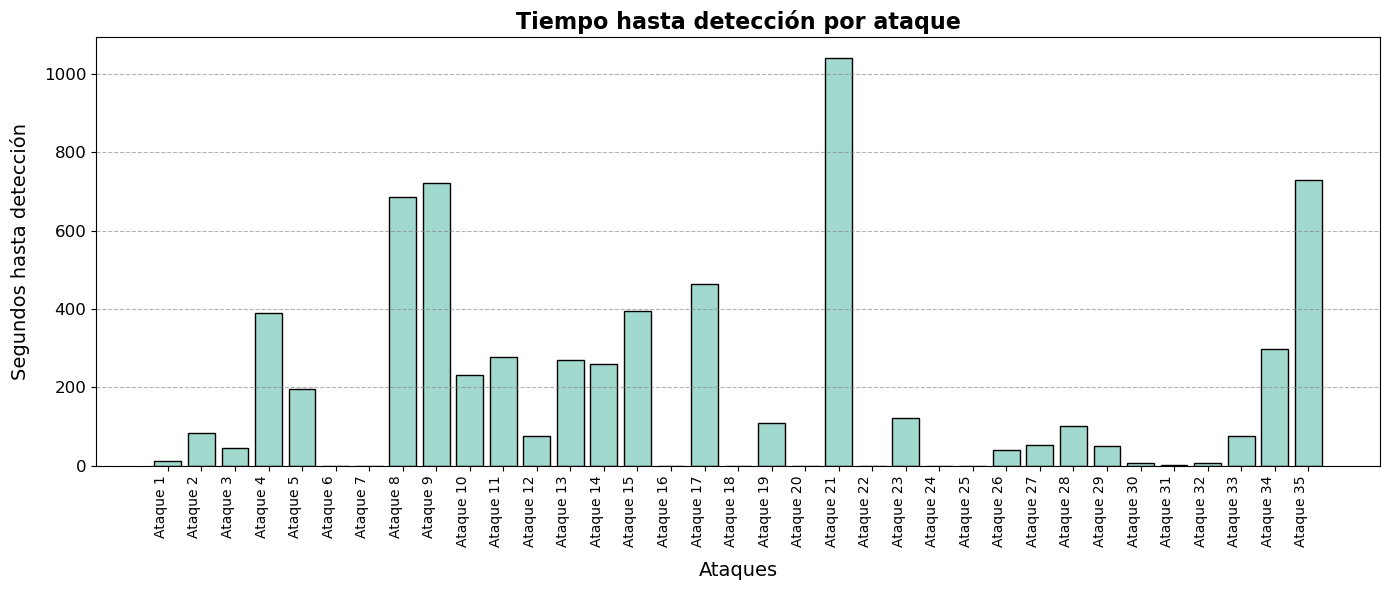

In [20]:
#gráfica para los resultados

ataques = [f"Ataque {i}" for i in range(1, 36)]
tiempos_deteccion = [
    12, 84, 46, 390, 196, 0, 0, 687, 721, 233, 277, 76, 269, 259,
    395, 0, 463, 0, 109, 0, 1042, 0, 121, 0, 0, 40, 52, 101, 51, 6,
    2, 8, 75, 297, 729
]

plt.figure(figsize=(14, 6))
plt.bar(ataques, tiempos_deteccion, color='#a2d9ce', edgecolor='black')  
plt.xticks(rotation=90, fontsize=10, ha='right')  #
plt.yticks(fontsize=12)

plt.xlabel("Ataques", fontsize=14, labelpad=10)
plt.ylabel("Segundos hasta detección", fontsize=14, labelpad=10)
plt.title("Tiempo hasta detección por ataque", fontsize=16, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')

plt.axhline(0, color='black',linewidth=0.5)

plt.tight_layout()

plt.show()

Muchos ataques consigue detectarlos al momento (6,7,16,18,20,22,24,25, ...) pero otros como el 21, el 8, el 9 o el 35 tarda bastante tiempo en detectar el comportamiento anómalo.

## 3. Cómo predice los sensores el regresor

Muestro todos los sensores en función de su valor real y el predicho por el regresor:

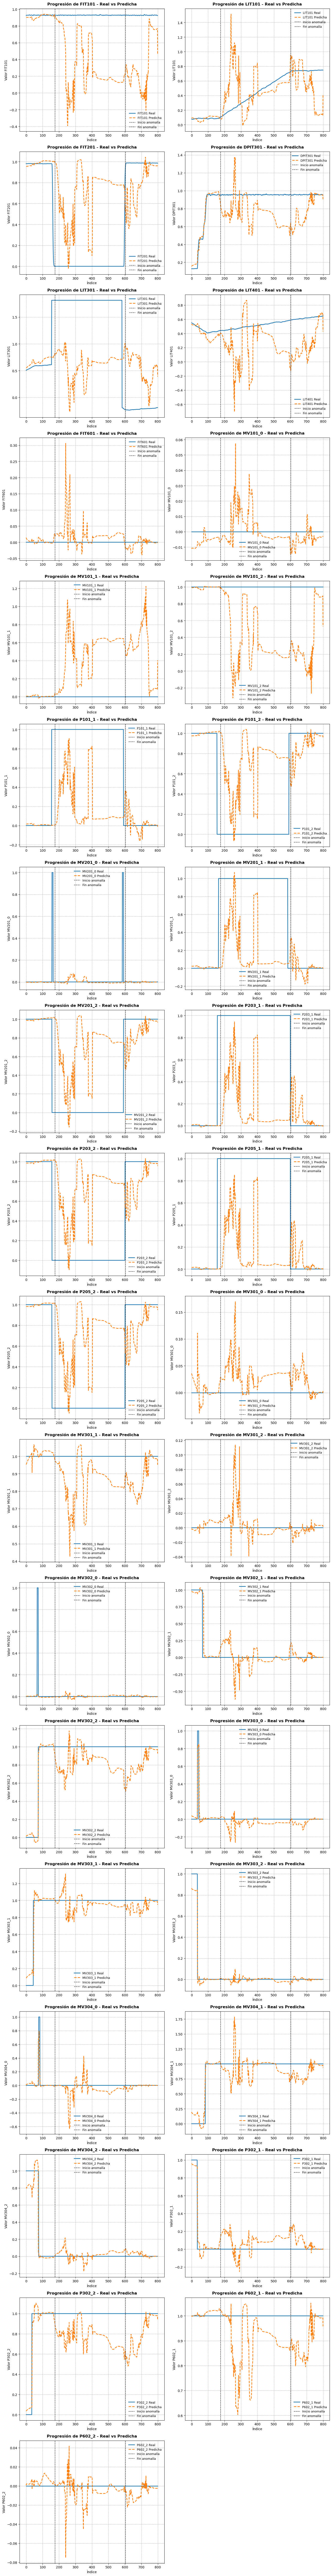

In [36]:
#Ponemos para observar ataque 6
df_anomalia_real1 = test.iloc[7400:8200]
df_anomalia_predicha1 = salida_modelo.iloc[7400:8200]

#restablecemos índices para evitar problemas
df_anomalia_real1 = df_anomalia_real1.reset_index(drop=True)
df_anomalia_predicha1 = df_anomalia_predicha1.reset_index(drop=True)

columnas = [
    'FIT101', 'LIT101', 'FIT201', 'DPIT301', 'LIT301', 'LIT401', 'FIT601','MV101_0',
    'MV101_1', 'MV101_2', 'P101_1', 'P101_2', 'MV201_0', 'MV201_1',
    'MV201_2', 'P203_1', 'P203_2', 'P205_1', 'P205_2', 'MV301_0', 'MV301_1',
    'MV301_2', 'MV302_0', 'MV302_1', 'MV302_2', 'MV303_0', 'MV303_1',
    'MV303_2', 'MV304_0', 'MV304_1', 'MV304_2', 'P302_1', 'P302_2',
    'P602_1', 'P602_2'
]

#filas por gráfica
num_filas = (len(columnas) + 1) // 2
plt.figure(figsize=(14, num_filas * 6))

#colores a usar
colores = ['#1f77b4', '#ff7f0e']  #azul para los valores reales, naranja para los valores predichos

for i, columna in enumerate(columnas):
    plt.subplot(num_filas, 2, i + 1)
    

    plt.plot(df_anomalia_real1[columna], label=f'{columna} Real', color=colores[0], linewidth=2)
    plt.plot(df_anomalia_predicha1[columna], label=f'{columna} Predicha', color=colores[1], linestyle='--', linewidth=2)

    #líneas verticales para las anomalías
    # la primera anomalía aparece en 1624, hemos hecho iloc en 1500:
    # 7575 - 7400 = 175
    plt.axvline(x=175, color='black', linestyle='--', label='Inicio anomalía', linewidth=1)
    # la primera anomalía termina en 2563, hemos hecho iloc en 1500:
    # 8003 - 7400 = 603
    plt.axvline(x=603, color='black', linestyle='--', label='Fin anomalía', linewidth=1)

    #título y etiquetas
    plt.title(f'Progresión de {columna} - Real vs Predicha', fontsize=12, fontweight='bold', pad=10)
    plt.xlabel('Índice', fontsize=10)
    plt.ylabel(f'Valor {columna}', fontsize=10)

    #leyenda
    plt.legend(loc='best', fontsize=9, frameon=False)

    #cuadrícula
    plt.grid(True, linestyle='--', alpha=0.6, color='gray')

plt.tight_layout()
plt.show()